In [33]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from IPython.display import display, HTML

%matplotlib inline
# from moses personal depence code:
from importance_and_dependence import (MyRandomForestClassifier,
                                       MyRandomForestRegressor,
                                       my_oob_permutation_importance,
                                       partial_dependence,
                                       partial_dependence_2d)

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, roc_auc_score

df_train = pd.read_csv('data/churn_train.csv', parse_dates=['last_trip_date', 'signup_date'])
df_test = pd.read_csv('data/churn_test.csv', parse_dates=['last_trip_date', 'signup_date'])
df_tot = pd.read_csv('data/churn.csv', parse_dates=['last_trip_date', 'signup_date'])

cutoff = cutoff = df_tot.last_trip_date.max() - pd.to_timedelta(30,'D')
def prepare_data(df):
    missing = df.isna().sum()
    clean_labels = missing[missing == 0].index
    dirtyl_labels = missing[missing > 0].index
    new_df = df[clean_labels]
    
    #to_keep = ['avg_dist', 'avg_surge', 'surge_pct', 'weekday_pct']
    to_keep = ['avg_dist','avg_surge', 'surge_pct', 'trips_in_first_30_days']
    filtered_df = new_df.loc[:, to_keep]
    
    y = df.last_trip_date <= cutoff
    return filtered_df, y

# X, y train/test variables:
train_X, train_y = prepare_data(df_train)
test_X, test_y = prepare_data(df_test)

# run model
rf = RandomForestClassifier()
model = rf.fit(train_X, train_y)
yhat = model.predict(test_X)

# Precision, Recall, Accuracy
def ezprint_cmatrix(ytrue, yhat):
    print("Precision: ", precision_score(ytrue, yhat))
    print("Recall: ", recall_score(ytrue, yhat))
    print("Accuracy score", accuracy_score(ytrue, yhat))

ezprint_cmatrix(test_y, yhat)

# ezprint_cmatrix(test_y, np.ones((len(yhat), 1)))

# Specificity
def specificity_score(y_true, y_pred):
    TN = len(y_true[y_true == y_pred and y_true == False])
    FP = len(y_true[y_true != y_pred and y_true == False])
    return TN / (TN + FP)

# Andrew added
df_train = prepare_data(df_train)[0]
df_test = prepare_data(df_test)[0]

Precision:  0.732718894009
Recall:  0.779288537549
Accuracy score 0.6806


In [48]:
df_train = pd.read_csv('data/churn_train.csv', parse_dates=['last_trip_date', 'signup_date'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
phone                     39681 non-null object
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.4+ MB


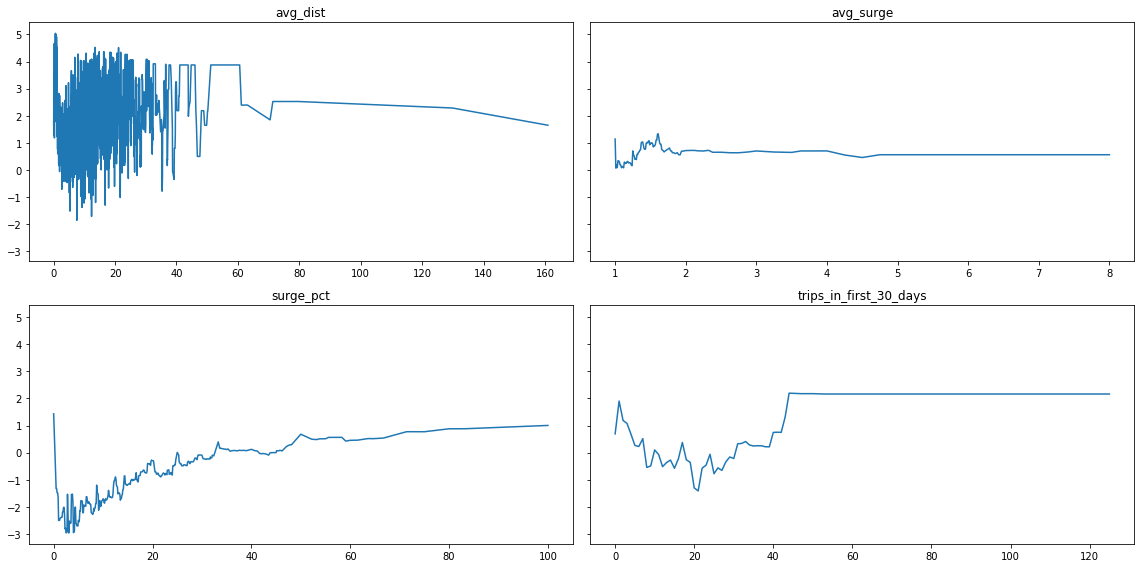

In [100]:
feature_indices = [0,1,2,3]

fig, axes = plt.subplots(2,2, figsize=(16,8), sharey=True, )

for ax, feat_ind in zip(axes.flatten(), feature_indices):
    xx, pdp = partial_dependence(model, train_X.values, feat_ind)
    ax.plot(xx, pdp)
    ax.set_title(df_train.columns[feat_ind])
plt.tight_layout()
plt.savefig('pdp_yeahyouknowme')

In [68]:
def profit_curve(cost_benefit, predicted_probs, labels):
    thresholds = np.append(predicted_probs, 1)
    thresholds.sort()
    profits = np.zeros((len(thresholds), 2))
    for idx,i in enumerate(thresholds):
        y_hat = (predicted_probs >= i)
        
        conf_mat = standard_conf_matrix(test_y.values, yhat)   
    
        profits[idx, 0] = (conf_mat * cost_benefit).sum() / labels.shape[0]
        profits[idx, 1] = i
        
    return profits

In [69]:
def standard_conf_matrix(y_true, y_predict):
    tp = ((y_true * y_predict) == 1).sum()
    fp = ((y_predict) * (1- y_true) == 1).sum()
    fn = ((1 - y_predict) * (y_true) == 1).sum()
    tn = ((1- y_predict) * (1 - y_true) == 1).sum()
    
    return np.array([[tp, fp],[fn, tn]])

In [85]:
probs = rf.predict_proba(test_X)
probs
#probs[1] is the prob churned

array([[ 0.35202877,  0.64797123],
       [ 0.10833333,  0.89166667],
       [ 0.        ,  1.        ],
       ..., 
       [ 0.9       ,  0.1       ],
       [ 0.02926333,  0.97073667],
       [ 0.28102314,  0.71897686]])

In [91]:
test_cost_benefit = np.array([[6, -3], [0, 0]])
profit_curve(test_cost_benefit, probs[1], test_y.values)

array([[ 2.5917    ,  0.10833333],
       [ 2.5917    ,  0.89166667],
       [ 2.5917    ,  1.        ]])

In [92]:
profits = profit_curve(test_cost_benefit, probs, test_y.values)
profits

array([[ 2.5917,  0.    ],
       [ 2.5917,  0.    ],
       [ 2.5917,  0.    ],
       ..., 
       [ 2.5917,  1.    ],
       [ 2.5917,  1.    ],
       [ 2.5917,  1.    ]])

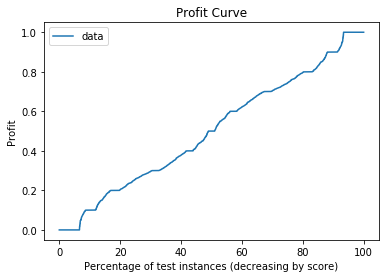

In [98]:

percentages = np.arange(0, 100, 100. / len(profits))
plt.plot(percentages, profits[:,1], label='data')
plt.title("Profit Curve")
plt.xlabel("Percentage of test instances (decreasing by score)")
plt.ylabel("Profit")
plt.legend(loc='best')
plt.savefig('profit_curve')
plt.show();


In [75]:
standard_conf_matrix(test_y.values,yhat)

array([[5423, 2207],
       [ 902, 1468]])

In [87]:
test_y

0        True
1        True
2        True
3        True
4        True
5       False
6        True
7        True
8        True
9        True
10       True
11       True
12      False
13      False
14      False
15       True
16       True
17      False
18      False
19      False
20      False
21       True
22       True
23       True
24       True
25       True
26       True
27      False
28       True
29       True
        ...  
9970     True
9971    False
9972    False
9973     True
9974    False
9975     True
9976    False
9977     True
9978     True
9979     True
9980     True
9981     True
9982     True
9983    False
9984     True
9985    False
9986     True
9987    False
9988     True
9989    False
9990    False
9991    False
9992     True
9993     True
9994     True
9995     True
9996     True
9997     True
9998     True
9999     True
Name: last_trip_date, Length: 10000, dtype: bool